In [1]:
%cd ..

c:\Workspace\Projects\Redcare\poc-call-analytics


c:\Workspace\Projects\Redcare\call_analytics\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from src.settings import PATH_LABELED, PATH_OPENAI_EMBEDDINGS, RANDOM_STATE

# 8_1 - Tagging

In [3]:
DEPARTMENT = "PS" # "CS" or "PS"
FEATURE = "summary_customer_only" # "transcription", "summary", "topics", "transcription_customer_only", "summary_customer_only"
LABEL = "Informational/Safety/Interaction effects"
# Options are (top-10 most common that are not "/Other") - CS:
# Support/Order & Delivery/Didn't receive order (yet)
# Transactional/Order & Delivery/Place order
# Informational/Prescription
# Support/Order & Delivery/Didn't receive everything they ordered
# Informational/Order & Delivery/What is the status of my order?
# Support/Payment & Discount/(Final) payment reminder
# Transactional/Order & Delivery/Update order
# Informational/Refund & Return/What is the status of my refund?
# Support/Order & Delivery/Received wrong item(s)
# Support/Payment & Discount/Can't pay

# Options are (top-5 most common that are not "/Other" or broad) - PS:
# Informational/Pharmaceutical Advice/Recommendation
# Informational/Product/Availability/Do you have this product in stock?
# Informational/Product/Usage
# Informational/Product/Availability/Do you have a product like this in your range?
# Informational/Safety/Interaction effects


OTHER_DEPARTMENT = "PS" if DEPARTMENT == "CS" else "CS"

if DEPARTMENT == "CS":
    FILE_PREFIX = "20250113_20250212_CS_"
    FILE_PREFIX_OTHER = "20250101_20250224_PS_"
elif DEPARTMENT == "PS":
    FILE_PREFIX = "20250101_20250224_PS_"
    FILE_PREFIX_OTHER = "20250113_20250212_CS_"

## Load Data

In [4]:
df_labeled_train = pd.read_csv(f"{PATH_LABELED}/labeled_train_{DEPARTMENT}.csv")
df_labeled_test = pd.read_csv(f"{PATH_LABELED}/labeled_test_{DEPARTMENT}.csv")
if FEATURE in ["transcription", "summary", "topics"]:
    df_embeddings = pd.read_csv(f"{PATH_OPENAI_EMBEDDINGS}/{FILE_PREFIX}{FEATURE}_embeddings_text-embedding-3-large.csv")
else:
    df_embeddings = pd.read_csv(f"{PATH_OPENAI_EMBEDDINGS}/{FILE_PREFIX}addedfeatures_{FEATURE}_embeddings_text-embedding-3-large.csv")

In [5]:
print(f"Number of rows in embeddings: {df_labeled_train.shape[0]}")

# Since something could have gone wrong in preprocessing, we will only keep the embeddings that are in the labeled data
df_labeled_train = df_labeled_train.merge(df_embeddings, on="id", how="inner")

print(f"Number of rows in embeddings after dropping unlabeled IDs: {df_labeled_train.shape[0]}")

Number of rows in embeddings: 828
Number of rows in embeddings after dropping unlabeled IDs: 828


In [6]:
print(f"Number of rows in embeddings: {df_labeled_test.shape[0]}")

# Since something could have gone wrong in preprocessing, we will only keep the embeddings that are in the labeled data
df_labeled_test = df_labeled_test.merge(df_embeddings, on="id", how="inner")

print(f"Number of rows in embeddings after dropping unlabeled IDs: {df_labeled_test.shape[0]}")

Number of rows in embeddings: 208
Number of rows in embeddings after dropping unlabeled IDs: 208


## Label Binarization

In [7]:
df_check = df_labeled_train.copy()
df_check["label"] = df_check["label"].apply(
    lambda x: [x for x in x.split(",")]
)
df_check = df_check.explode("label")
print(f"Number of calls in train with \'{LABEL}\' in labels: {df_check.label.value_counts()[LABEL]}")

Number of calls in train with 'Informational/Safety/Interaction effects' in labels: 50


In [8]:
if LABEL == "Support/Order & Delivery/Didn't receive order (yet)":
    df_labeled_train[LABEL] = df_labeled_train["label"].apply(lambda x: 1 if LABEL in x or "Informational/Order & Delivery/What is the status of my order?" in x else 0)
elif LABEL == "Informational/Product/Availability/Do you have this product in stock?":
    df_labeled_train[LABEL] = df_labeled_train["label"].apply(lambda x: 1 if LABEL in x or "Informational/Product/Availability/Do you have a product like this in your range?" in x else 0)
else:
    df_labeled_train[LABEL] = df_labeled_train["label"].apply(lambda x: 1 if LABEL in x else 0)
df_labeled_train[LABEL] = df_labeled_train[LABEL].astype(int)
df_labeled_train[LABEL].value_counts()

Informational/Safety/Interaction effects
0    778
1     50
Name: count, dtype: int64

In [9]:
if LABEL == "Support/Order & Delivery/Didn't receive order (yet)":
    df_labeled_test[LABEL] = df_labeled_test["label"].apply(lambda x: 1 if LABEL in x or "Informational/Order & Delivery/What is the status of my order?" in x else 0)
elif LABEL == "Informational/Product/Availability/Do you have this product in stock?":
    df_labeled_test[LABEL] = df_labeled_test["label"].apply(lambda x: 1 if LABEL in x or "Informational/Product/Availability/Do you have a product like this in your range?" in x else 0)
else:
    df_labeled_test[LABEL] = df_labeled_test["label"].apply(lambda x: 1 if LABEL in x else 0)
df_labeled_test[LABEL] = df_labeled_test[LABEL].astype(int)
df_labeled_test[LABEL].value_counts()

Informational/Safety/Interaction effects
0    195
1     13
Name: count, dtype: int64

## Balancing Training Data

Not going for completely balanced here, but for more balanced. Taking the closest integer ratio, but limiting this at 1 pos : 19 neg.

In [10]:
X_train_pos = df_labeled_train[df_labeled_train[LABEL] == 1]
print(f"Number of positive samples in train: {X_train_pos.shape[0]}")
ratio = min([4, math.floor(df_labeled_train.shape[0] / X_train_pos.shape[0])-1])
X_train_neg = df_labeled_train[df_labeled_train[LABEL] == 0].sample(n=ratio*X_train_pos.shape[0], random_state=RANDOM_STATE)
print(f"Number of negative samples in train: {X_train_neg.shape[0]}")
X_train = pd.concat([X_train_pos, X_train_neg])
X_train = X_train.drop(columns=["id", "usage", "label", LABEL])
y_train = df_labeled_train[LABEL][X_train.index]
print(f"Number of samples in y train: {y_train.shape[0]}")

Number of positive samples in train: 50
Number of negative samples in train: 200
Number of samples in y train: 250


## Features

In [11]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)

In [12]:
X_test = df_labeled_test.drop(columns=["id", "usage", "label", LABEL])
X_test = mms.transform(X_test)
y_test = df_labeled_test[LABEL]

## Modeling

asd

In [13]:
models = {
    # 'LogisticRegression': {
    #     'model': LogisticRegression(solver='liblinear'),
    #     'params': {
    #         'C': [0.1, 1, 10]
    #     }
    # },
    # 'RandomForest': {
    #     'model': RandomForestClassifier(),
    #     'params': {
    #         'n_estimators': [25, 50, 100],
    #         'max_depth': [None, 10, 20]
    #     }
    # },
    # 'MLPClassifier': {
    #     'model': MLPClassifier(max_iter=500, solver='lbfgs'),
    #     'params': {
    #         'hidden_layer_sizes': [(50,), (100,)],
    #         'alpha': [0.0001, 0.001]
    #     }
    # },
    'ComplementNB': {
        'model': ComplementNB(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 50],  # Regularization strength
            'kernel': ['linear', 'rbf'],  # Different decision boundaries
            'gamma': ['scale', 'auto'],  # Kernel coefficient (ignored for linear)
        }
    }
}

In [14]:
# Define Stratified K-Fold for multilabel classification
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [15]:
# Define scoring function (F1 score is often better for multilabel problems)
scorer = make_scorer(f1_score, average='binary')

In [16]:
best_models = {}

# Iterate over models and perform Grid Search
for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")
    
    grid_search = GridSearchCV(
        model_info['model'], 
        model_info['params'], 
        cv=cv, 
        scoring=scorer, 
        n_jobs=-1, 
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store the best model for each classifier
    best_models[model_name] = grid_search.best_estimator_
    
    # Print the best hyperparameters
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")


Training ComplementNB...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters for ComplementNB: {'alpha': 0.1}

Training SVC...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for SVC: {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}



=== ComplementNB Performance ===
Train - F1 Score: 0.8073
Train - Accuracy: 0.9160
Train - Precision: 0.7458
Train - Recall: 0.8800


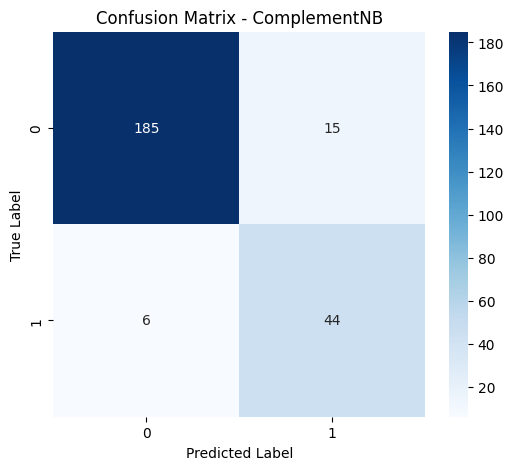


=== SVC Performance ===
Train - F1 Score: 1.0000
Train - Accuracy: 1.0000
Train - Precision: 1.0000
Train - Recall: 1.0000


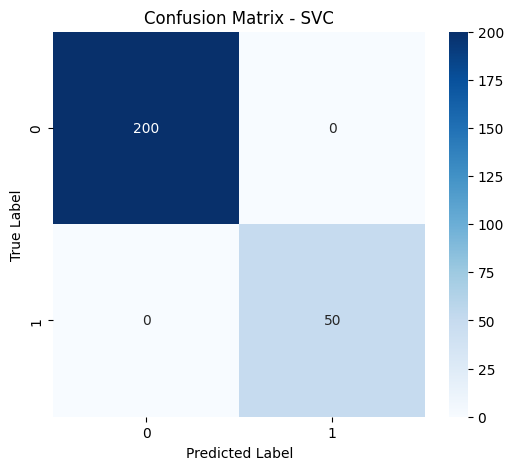

In [17]:
# Evaluate all models
for model_name, model in best_models.items():
    y_pred = model.predict(X_train)
    f1 = f1_score(y_train, y_pred, average='binary')
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='binary')
    recall = recall_score(y_train, y_pred, average='binary')
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Train - F1 Score: {f1:.4f}")
    print(f"Train - Accuracy: {accuracy:.4f}")
    print(f"Train - Precision: {precision:.4f}")
    print(f"Train - Recall: {recall:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


=== ComplementNB Performance ===
Test - F1 Score: 0.5000
Test - Accuracy: 0.9135
Test - Precision: 0.3913
Test - Recall: 0.6923


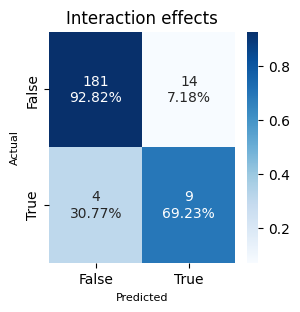

Misclassified indices: [ 21  26  33  34  62  63  75  80  81 114 119 135 137 141 143 146 178 181]

Misclassified cases for ComplementNB:
Index: 21, True Label: 1, Predicted: 0, Call ID: 2605096675
Index: 26, True Label: 0, Predicted: 1, Call ID: 2504066811
Index: 33, True Label: 0, Predicted: 1, Call ID: 2518616054
Index: 34, True Label: 1, Predicted: 0, Call ID: 2595503219
Index: 62, True Label: 1, Predicted: 0, Call ID: 2560200691
Index: 63, True Label: 0, Predicted: 1, Call ID: 2541274164
Index: 75, True Label: 0, Predicted: 1, Call ID: 2595619220
Index: 80, True Label: 0, Predicted: 1, Call ID: 2496660155
Index: 81, True Label: 0, Predicted: 1, Call ID: 2604923266
Index: 114, True Label: 0, Predicted: 1, Call ID: 2557719365
Index: 119, True Label: 0, Predicted: 1, Call ID: 2579257191
Index: 135, True Label: 0, Predicted: 1, Call ID: 2607494446
Index: 137, True Label: 1, Predicted: 0, Call ID: 2589645227
Index: 141, True Label: 0, Predicted: 1, Call ID: 2545881583
Index: 143, True La

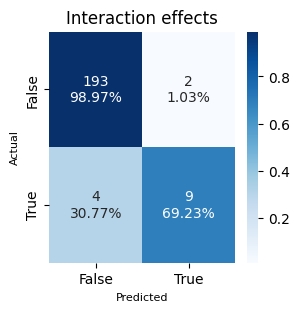

Misclassified indices: [ 34  62 114 138 148 167]

Misclassified cases for SVC:
Index: 34, True Label: 1, Predicted: 0, Call ID: 2595503219
Index: 62, True Label: 1, Predicted: 0, Call ID: 2560200691
Index: 114, True Label: 0, Predicted: 1, Call ID: 2557719365
Index: 138, True Label: 1, Predicted: 0, Call ID: 2576786852
Index: 148, True Label: 0, Predicted: 1, Call ID: 2545782521
Index: 167, True Label: 1, Predicted: 0, Call ID: 2538690386


In [18]:
# Evaluate all models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Test - F1 Score: {f1:.4f}")
    print(f"Test - Accuracy: {accuracy:.4f}")
    print(f"Test - Precision: {precision:.4f}")
    print(f"Test - Recall: {recall:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = confusion_matrix(y_test, y_pred, normalize='true')
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    # Normalizes percentages over true labels (rows)
    group_percentages = [
        "{0:.2%}".format(value)
        for value in np.nan_to_num(cm / cm.sum(axis=1, keepdims=True)).flatten()
    ]
    annotations = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annotations = np.asarray(annotations).reshape(cm.shape)
    plt.figure(figsize=(3, 3))
    sns.heatmap(
        cm_plot,
        annot=annotations,
        fmt="",
        cmap="Blues",
        xticklabels=["False", "True"],
        yticklabels=["False", "True"],
    )
    
    # Plot confusion matrix
    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'{LABEL.split("/")[-1]}', fontsize=12)
    plt.show()

    # Identify misclassified cases
    misclassified_indices = np.where(y_test != y_pred)[0]  # Get indices where y and y_pred differ
    print(f"Misclassified indices: {misclassified_indices}")
    if len(misclassified_indices) > 0:
        print(f"\nMisclassified cases for {model_name}:")
        for idx in misclassified_indices:
            print(f"Index: {idx}, True Label: {y_test[idx]}, Predicted: {y_pred[idx]}, Call ID: {df_labeled_test.iloc[idx]['id']}")
    else:
        print(f"\nNo misclassified cases for {model_name}.")

In [20]:
import pickle


for model_name, model in best_models.items():
    # Save the model to disk
    filename = f"{model_name}_{DEPARTMENT}_{LABEL.split('/')[-1]}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model, f)

## Test on Data for Other Department

This is only really relevant if the same labels exists in both hierarchies.

In [ ]:
if LABEL == "Transactional/Order & Delivery/Place order":
    LABEL = "/".join(LABEL.split("/")[:2])

df_labeled_test_otherdep = pd.read_csv(f"{PATH_LABELED}/labeled_test_{OTHER_DEPARTMENT}.csv")
df_embeddings_otherdep = pd.read_csv(f"{PATH_OPENAI_EMBEDDINGS}/{FILE_PREFIX_OTHER}{FEATURE}_embeddings_text-embedding-3-large.csv")

print(f"Number of rows in embeddings: {df_labeled_test_otherdep.shape[0]}")

# Since something could have gone wrong in preprocessing, we will only keep the embeddings that are in the labeled data
df_labeled_test_otherdep = df_labeled_test_otherdep.merge(df_embeddings_otherdep, on="id", how="inner")

print(f"Number of rows in embeddings after dropping unlabeled IDs: {df_labeled_test_otherdep.shape[0]}")

df_labeled_test_otherdep[LABEL] = df_labeled_test_otherdep["label"].apply(lambda x: 1 if LABEL in x else 0)
df_labeled_test_otherdep[LABEL] = df_labeled_test_otherdep[LABEL].astype(int)
df_labeled_test_otherdep[LABEL].value_counts()

X_test_otherdep = df_labeled_test_otherdep.drop(columns=["id", "usage", "label", LABEL])
y_test_otherdep = df_labeled_test_otherdep[LABEL]

In [ ]:
# Evaluate all models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_otherdep)
    f1 = f1_score(y_test_otherdep, y_pred, average='macro')
    accuracy = accuracy_score(y_test_otherdep, y_pred)
    precision = precision_score(y_test_otherdep, y_pred, average='macro')
    recall = recall_score(y_test_otherdep, y_pred, average='macro')
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Test - F1 Score: {f1:.4f}")
    print(f"Test - Accuracy: {accuracy:.4f}")
    print(f"Test - Precision: {precision:.4f}")
    print(f"Test - Recall: {recall:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test_otherdep, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Identify misclassified cases
    misclassified_indices = np.where(y_test_otherdep != y_pred)[0]  # Get indices where y and y_pred differ
    print(f"Misclassified indices: {misclassified_indices}")
    if len(misclassified_indices) > 0:
        print(f"\nMisclassified cases for {model_name}:")
        for idx in misclassified_indices:
            print(f"Index: {idx}, True Label: {y_test_otherdep[idx]}, Predicted: {y_pred[idx]}, Call ID: {df_labeled_test_otherdep.iloc[idx]['id']}")
    else:
        print(f"\nNo misclassified cases for {model_name}.")